In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm

In [2]:
%config InlineBackend.figure_format = 'retina'
#az.style.use('arviz-darkgrid')
sns.set_style('darkgrid')

In [3]:
def calculate_metrics(cumret):
    '''
    calculate performance metrics from cumulative returns
    '''
    total_return = (cumret[-1] - cumret[0])/cumret[0]
    apr = (1+total_return)**(252/len(cumret)) - 1
    rets = pd.DataFrame(cumret).pct_change()
    rets.iloc[0] = 0
    sharpe = np.sqrt(252) * np.nanmean(rets) / np.nanstd(rets)
    
    # maxdd and maxddd
    highwatermark=np.zeros(cumret.shape)
    drawdown=np.zeros(cumret.shape)
    drawdownduration=np.zeros(cumret.shape)
    for t in np.arange(1, cumret.shape[0]):
        highwatermark[t]=np.maximum(highwatermark[t-1], cumret[t])
        drawdown[t]=cumret[t]/highwatermark[t]-1
        if drawdown[t]==0:
            drawdownduration[t]=0
        else:
            drawdownduration[t]=drawdownduration[t-1]+1
    maxDD=np.min(drawdown)
    maxDDD=np.max(drawdownduration)
    
    return total_return, apr, sharpe, maxDD, maxDDD

In [4]:
def generate_par(N, rho, sigma_M, sigma_R):
    '''
    Generate PAR sample of length N with parameters rho, sigma_M, sigma_R
    '''
    from statsmodels.tsa.arima_process import arma_generate_sample
    
    ar_M = np.r_[1, -rho]
    ar_R = np.r_[1, -1]
    ma = np.r_[1]

    M = arma_generate_sample(ar_M, ma, N, scale=sigma_M)
    R = arma_generate_sample(ar_R, ma, N, scale=sigma_R)
    
    return M+R

In [5]:
def calculate_Rsq(rho, sigma_M, sigma_R):
    '''
    Calculate R^2 - proportion of variance attributable to mean reversion
    '''    
    return (2*sigma_M**2) / (2*sigma_M**2 + (1+rho) * sigma_R**2)

In [6]:
def lagvar_estimate_par(X):
    '''
    estimate parameters of partial AR model using lagged variances
    '''
    
    # calculate lagged variances
    v1 = np.var(X[1:] - X[:-1])
    v2 = np.var(X[2:] - X[:-2])
    v3 = np.var(X[3:] - X[:-3])
    
    # rho
    rho_lv = -(v1 - 2*v2 + v3) / (2*v1 - v2)
    
    # sigma_M
    if (rho_lv+1) / (rho_lv-1) * (v2 - 2*v1) > 0:
        sigma_M_lv = np.sqrt(1/2 * (rho_lv+1) / (rho_lv-1) * (v2 - 2*v1))
    else:
        sigma_M_lv = 0
        
    # sigma_R
    if v2 > 2*sigma_M_lv**2:
        sigma_R_lv = np.sqrt(1/2 * (v2 - 2*sigma_M_lv**2))
    else:
        sigma_R_lv = 0
    
    return rho_lv, sigma_M_lv, sigma_R_lv

def lagvar_estimate_rw(X):
    '''
    estimate parameters of randow walk model using lagged variances
    '''
    
    # calculate lagged variances
    v1 = np.var(X[1:] - X[:-1])
    v2 = np.var(X[2:] - X[:-2])
    v3 = np.var(X[3:] - X[:-3])
    
    # rho
    rho_lv = 0
    # sigma_M
    sigma_M_lv = 0
    # sigma_R
    sigma_R_lv = np.sqrt(1/2 * (v2 - 2*sigma_M_lv**2))
    
    return sigma_R_lv

def lagvar_estimate_ar(X):
    '''
    estimate parameters of AR model using lagged variances
    '''
    
    # calculate lagged variances
    v1 = np.var(X[1:] - X[:-1])
    v2 = np.var(X[2:] - X[:-2])
    v3 = np.var(X[3:] - X[:-3])
    
    # rho
    rho_lv = -(v1 - 2*v2 + v3) / (2*v1 - v2)
    # sigma_M
    if (rho_lv+1) / (rho_lv-1) * (v2 - 2*v1) > 0:
        sigma_M_lv = np.sqrt(1/2 * (rho_lv+1) / (rho_lv-1) * (v2 - 2*v1))
    else:
        sigma_M_lv = 0
    
    return rho_lv, sigma_M_lv

In [7]:
def kalman_estimate(X, rho, sigma_M, sigma_R):
    '''
    Calculate estimates of mean-reverting and random walk components
    '''
    
    # create arrays for storing both components and prediction errors
    M = np.zeros(len(X))
    R = np.zeros(len(X))
    eps = np.zeros(len(X))
    
    # set initial state
    if sigma_R==0:
        M[0] = X[0]
        R[0] = 0
    else:
        M[0] = 0
        R[0] = X[0]
    
    # calculate Kalman gain    
    if sigma_M==0:
        K_M = 0
        K_R = 1
    elif sigma_R==0:
        K_M = 1
        K_R = 0
    else:
        sqr = np.sqrt((1+rho)**2 * sigma_R**2 + 4*sigma_M**2)
        K_M = 2*sigma_M**2 / (sigma_R * (sqr + rho*sigma_R + sigma_R) + 2*sigma_M**2)
        K_R = 2*sigma_R / (sqr - rho*sigma_R + sigma_R)
    
    # calculate estimates
    for i in range(1, len(X)):
        xhat = rho * M[i-1] + R[i-1]
        eps[i] = X[i] - xhat
        M[i] = rho * M[i-1] + eps[i] * K_M
        R[i] = R[i-1] + eps[i] * K_R
        
    return M, R, eps

def log_like(X, rho, sigma_M, sigma_R):
    '''
    Compute log likelihood function
    '''
    
    N = len(X)
    _,_,eps = kalman_estimate(X, rho, sigma_M, sigma_R)
    ll = -(N-1)/2 * np.log(2*np.pi * (sigma_M**2 + sigma_R**2)) - 1 / (2 * (sigma_M**2 + sigma_R**2)) * np.sum(eps[1:]**2)
    
    return ll

def f_to_min_par(parameters, X):
    rho, sigma_M, sigma_R = parameters
    return -log_like(X, rho, sigma_M, sigma_R)

def f_to_min_rw(sigma_R, X):
    rho = 0
    sigma_M = 0 # remove mean-reverting component
    return -log_like(X, rho, sigma_M, sigma_R)

def f_to_min_ar(parameters, X):
    rho, sigma_M = parameters
    sigma_R = 0 # remove random walk component
    return -log_like(X, rho, sigma_M, sigma_R)

from scipy.optimize import minimize
from scipy import stats

# distribution for random guesses
rnd_rho = stats.uniform(loc=-1, scale=2)

def fit_par(X, mode, tol=0.001):
    '''
    fit PAR model using MLE
    '''
    
    estimates = []
    lls = []
    
    if mode=='PAR':
        # get initial guesses using lagged variances
        x0 = lagvar_estimate_par(X)
        # set boundaries
        bounds = ((-1,1), (0,np.inf), (0,np.inf))
        # function to use in minimization
        f_to_min = f_to_min_par
        # function to generate random initial values
        std = np.std(np.diff(X))
        rnd_sigma = stats.norm(loc=std, scale=std/2)
        def gen_x0():
            return rnd_rho.rvs(), rnd_sigma.rvs(), rnd_sigma.rvs()
        
    elif mode=='AR':
        x0 = lagvar_estimate_ar(X)
        bounds = ((-1,1), (0,np.inf))
        f_to_min = f_to_min_ar
        std = np.std(np.diff(X))
        rnd_sigma = stats.norm(loc=std, scale=std/2)
        def gen_x0():
            return rnd_rho.rvs(), rnd_sigma.rvs()
        
    elif mode=='RW':
        x0 = lagvar_estimate_rw(X)
        bounds = ((0,np.inf),)
        f_to_min = f_to_min_rw
        std = np.std(np.diff(X))
        rnd_sigma = stats.norm(loc=std, scale=std/2)
        def gen_x0():
            return rnd_sigma.rvs()
    
    # minimize
    res = minimize(f_to_min, (x0), args=(X), bounds=bounds, tol=tol)
    
    if res.success:
        estimates.append(res.x)
        lls.append(-res.fun) # save log-likelihood
    
    # repeat minimization with different (random) initial values
    n_att = 0
    while len(lls)<10 and n_att<100: 
        n_att += 1
        x0 = gen_x0()
        res = minimize(f_to_min, (x0), args=(X), bounds=bounds, tol=tol)
        if res.success:
            estimates.append(res.x)
            lls.append(-res.fun) # save log-likelihood
    
    try:
        argmax = np.argmax(lls) # index of the biggest likelihood
        return estimates[argmax]
    except:
        print('Estimation failed!')
        return len(x0)*[np.nan] # return nans

# Partial cointegration model

In [8]:
def generate_pci(N, *params):
    '''
    Generate two partially cointegrated time series of length N with given parameters
    '''
    alpha,beta,sigma_X,rho,sigma_M,sigma_R = params
    
    ret_X1 = sigma_X * np.random.randn(N)
    X1 = 100*np.exp(np.cumsum(ret_X1)) # generate X1
    W = generate_par(N, rho, sigma_M, sigma_R) # generate PAR residual
    X2 = alpha + beta*X1 + W # compute X2
    
    return X1,X2

In [9]:
# set parameters
alpha = 5
beta = 1
sigma_X = 0.0236
rho = 0.7
sigma_M = 0.6
sigma_R = 0.4
N = 1125

# generate data
np.random.seed(1)
X1,X2 = generate_pci(N, alpha,beta,sigma_X,rho,sigma_M,sigma_R)

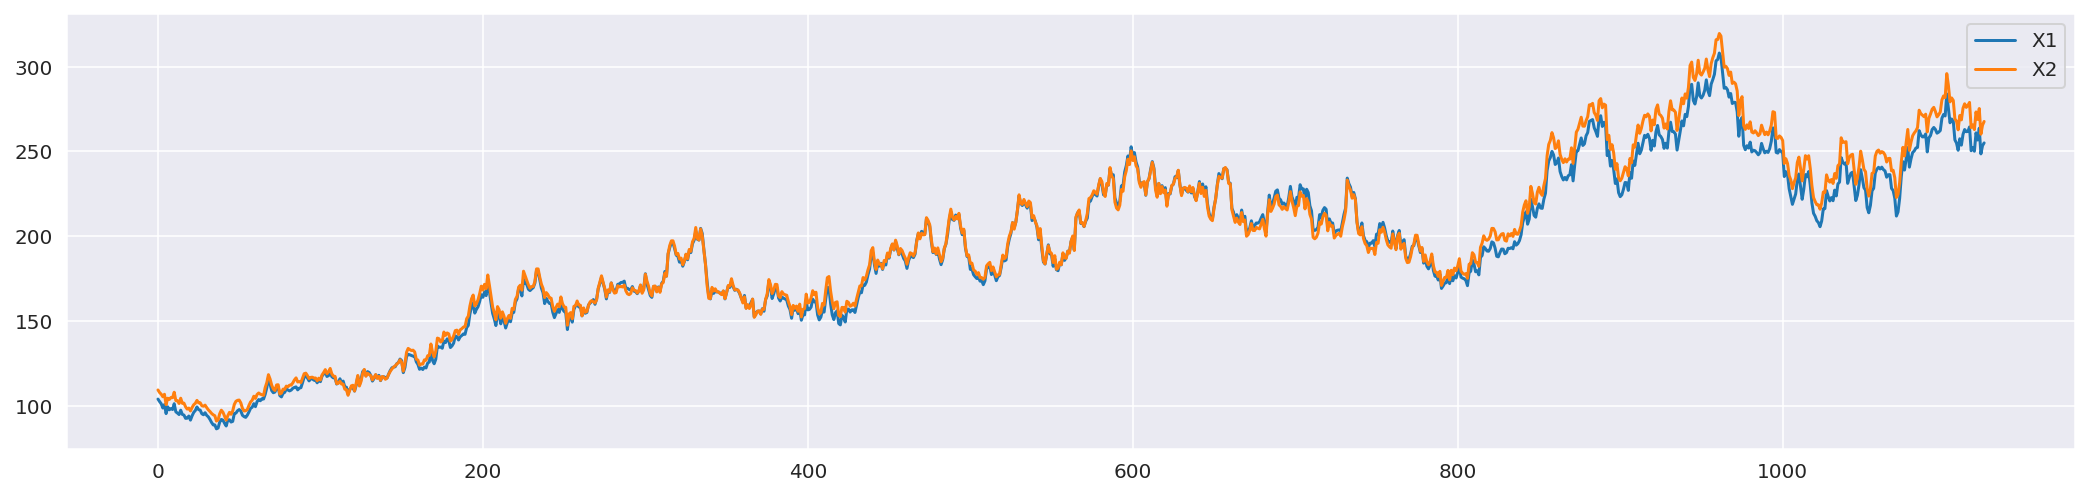

In [10]:
plt.figure(figsize=(18,4))
plt.plot(X1, label='X1')
plt.plot(X2, label='X2')
plt.legend()

In [11]:
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen

In [12]:
res = coint_johansen(np.array([X1,X2]).T, det_order=0, k_ar_diff=1)
(res.lr2 > res.cvm[:,1]).sum() # must be 2 to reject the null at 95%

0

In [13]:
coint(X2,X1)

(-2.1588055388595406,
 0.44569701268028095,
 array([-3.90621022, -3.34157143, -3.04822546]))

In [14]:
coint(X1,X2)

(-2.27823122179215,
 0.3844640215042534,
 array([-3.90621022, -3.34157143, -3.04822546]))

### Fitting PCI model

In [15]:
import statsmodels.api as sm

def fit_pci(X1, X2, mode='PAR', tol=0.001):
    '''
    fit partial cointegration model to time series X1 and X2
    X2 = alpha + beta * X1 + W
    '''
    
    # calculate initial guess for beta
    res = sm.OLS(np.diff(X2), np.diff(X1)).fit()
    beta0 = res.params[0]
    
    # calculate initial guess for alpha
    alpha0 = X2[0] - beta0 * X1[0]
    
    # calculate initial guesses for rho, sigma_M, sigma_R
    W = X2 - alpha0 - beta0 * X1
    params0 = fit_par(W, mode=mode)
    
    # perform optimization depending on the mode
    if mode=='PAR':
        def f_to_min_pci(parameters, X1, X2):
            alpha,beta,rho,sigma_M,sigma_R = parameters
            W = X2 - beta*X1 - alpha
            return -log_like(W, rho, sigma_M, sigma_R)
        
        x0 = (alpha0, beta0, *params0) # initial guess
        res = minimize(f_to_min_pci, x0, args=(X1, X2), tol=tol)
        alpha,beta,rho,sigma_M,sigma_R = res.x
        ll = -res.fun
    
    elif mode=='AR':
        def f_to_min_pci(parameters, X1, X2):
            alpha,beta,rho,sigma_M = parameters
            sigma_R = 0
            W = X2 - beta*X1 - alpha
            return -log_like(W, rho, sigma_M, sigma_R)
        
        x0 = (alpha0, beta0, *params0) # initial guess
        res = minimize(f_to_min_pci, x0, args=(X1, X2), tol=tol)
        alpha,beta,rho,sigma_M = res.x
        sigma_R = 0
        ll = -res.fun
    
    elif mode=='RW':
        def f_to_min_pci(parameters, X1, X2):
            alpha,beta,sigma_R = parameters
            rho = 0
            sigma_M = 0
            W = X2 - beta*X1 - alpha
            return -log_like(W, rho, sigma_M, sigma_R)
        
        x0 = (alpha0, beta0, *params0) # initial guess
        res = minimize(f_to_min_pci, x0, args=(X1, X2), tol=tol)
        alpha,beta,sigma_R = res.x
        rho = 0
        sigma_M = 0
        ll = -res.fun
    
    return alpha, beta, rho, sigma_M, sigma_R, ll

In [16]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    alpha_hat,beta_hat,rho_hat,sigmaM_hat,sigmaR_hat,ll = fit_pci(X1,X2, mode='PAR')

print(f'alpha = {alpha_hat}')
print(f'beta = {beta_hat}')
print(f'rho = {rho_hat}')
print(f'sigma_M = {sigmaM_hat}')
print(f'sigma_R = {sigmaR_hat}')
print(f'log-likelihood = {ll}')

alpha = 4.569983803086217
beta = 1.0074367374270263
rho = 0.7169952497319807
sigma_M = 0.6311323701180158
sigma_R = 0.39027637149483146
log-likelihood = -1259.5599089037134


In [17]:
calculate_Rsq(rho, sigma_M, sigma_R)

0.7258064516129032

# Trading on synthetic data

In [18]:
prices = pd.DataFrame(index=np.arange(len(X1)), columns=['S1','S2'])
prices['S1'] = X1
prices['S2'] = X2
returns = prices.pct_change()

In [19]:
prices_train = prices.iloc[:1000]
prices_test = prices.iloc[1000:]
returns_train = returns.iloc[:1000]
returns_test = returns.iloc[1000:]

### Standard cointegration

In [20]:
res = sm.OLS(prices_train['S2'].values, sm.add_constant(prices_train['S1'].values)).fit()
alpha, beta = res.params
spread_train = prices_train['S2'] - alpha - beta*prices_train['S1']

In [21]:
mean = spread_train.mean()
sd = spread_train.std()

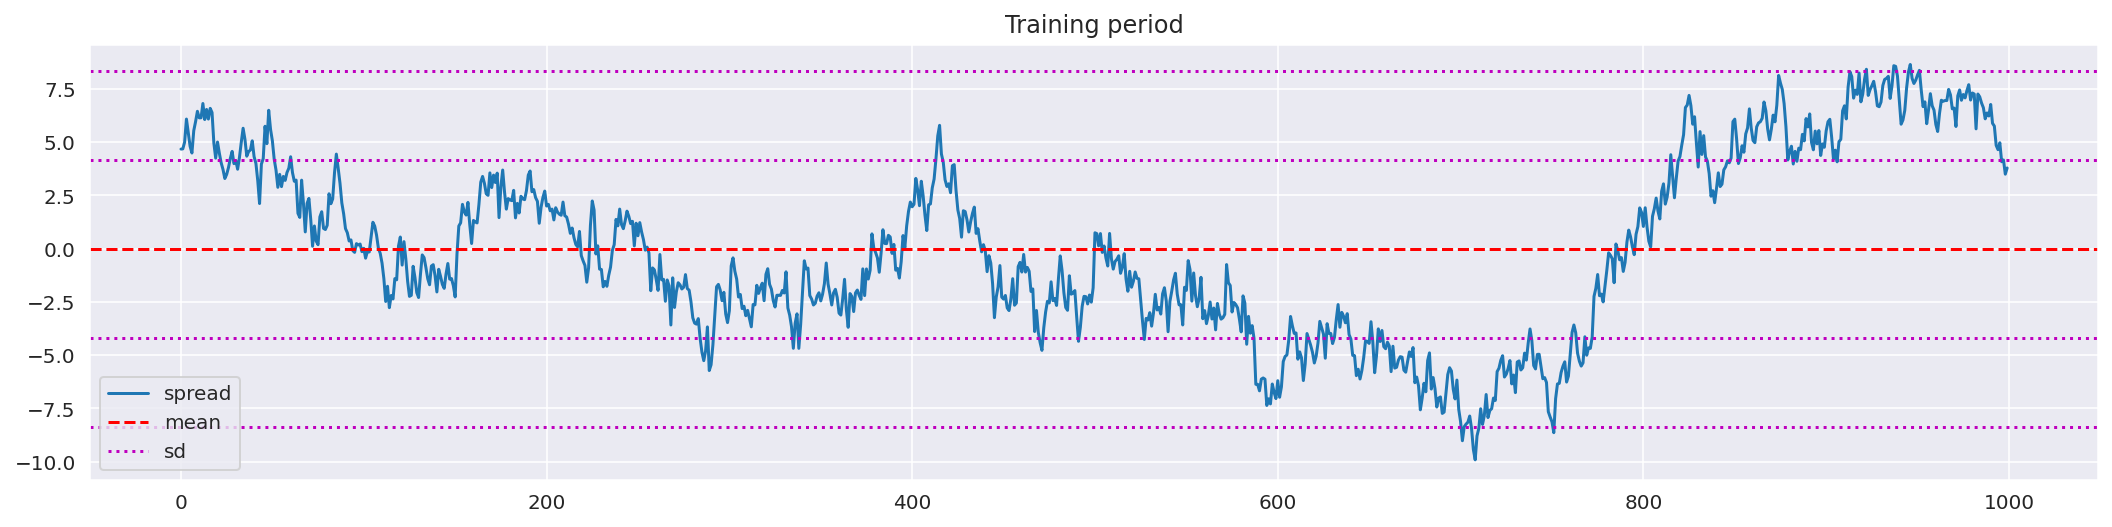

In [22]:
plt.figure(figsize=(18,4))
plt.title('Training period')
plt.plot(spread_train, label='spread')
plt.axhline(mean, label='mean', color='r', linestyle='dashed')
plt.axhline(mean-sd, label='sd', color='m', linestyle='dotted')
plt.axhline(mean-2*sd, color='m', linestyle='dotted')
plt.axhline(mean+sd, color='m', linestyle='dotted')
plt.axhline(mean+2*sd, color='m', linestyle='dotted')
plt.legend()

In [23]:
spread_test = prices_test['S2'] - alpha - beta*prices_test['S1']

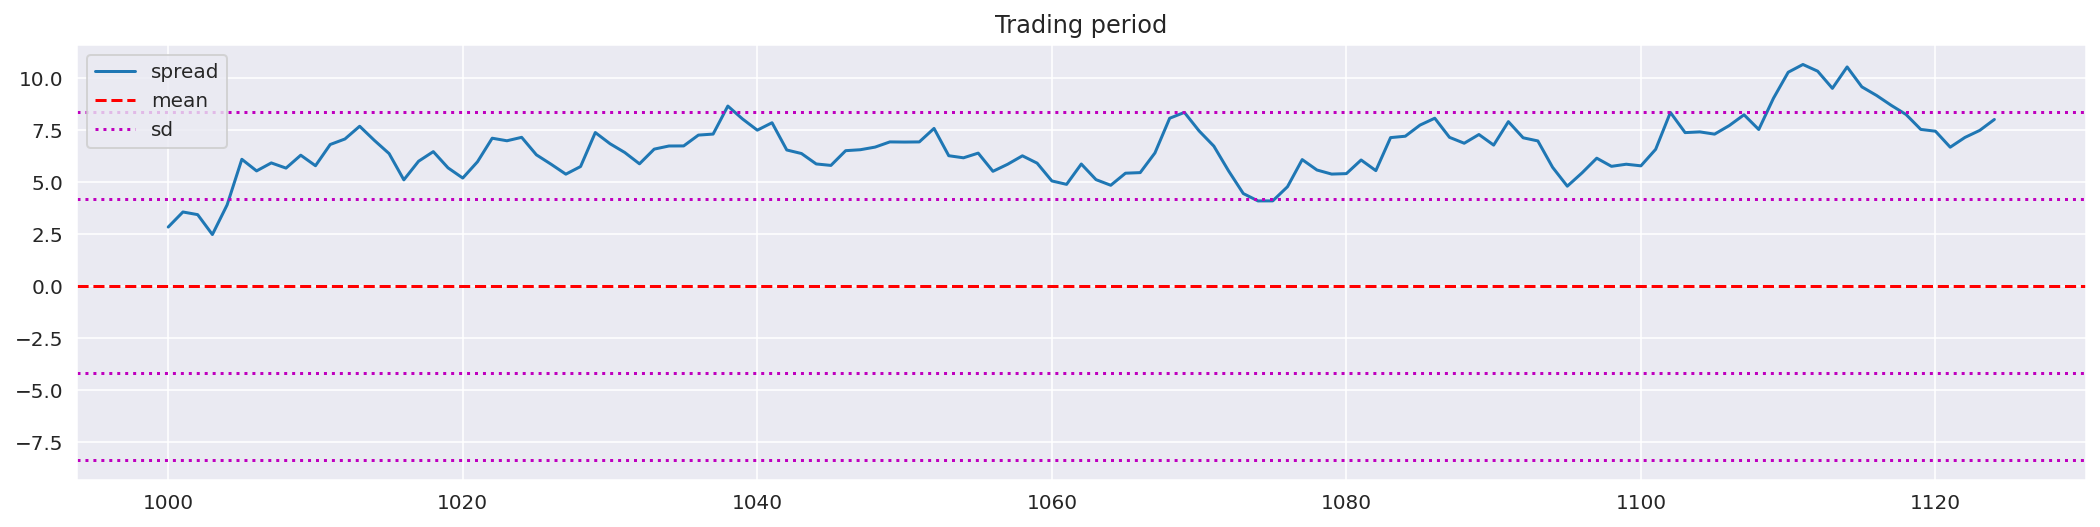

In [24]:
plt.figure(figsize=(18,4))
plt.title('Trading period')
plt.plot(spread_test, label='spread')
plt.axhline(mean, label='mean', color='r', linestyle='dashed')
plt.axhline(mean-sd, label='sd', color='m', linestyle='dotted')
plt.axhline(mean-2*sd, color='m', linestyle='dotted')
plt.axhline(mean+sd, color='m', linestyle='dotted')
plt.axhline(mean+2*sd, color='m', linestyle='dotted')
plt.legend()

In [25]:
# calculate positions
positions = pd.DataFrame(index=prices_test.index, columns=prices_test.columns)

# indicators of long\short positions
short = False
long = False

for t in spread_test.index:
    if spread_test.loc[t] > 2*sd:
        short = True
        positions.loc[t] = [1,-1] # open short position
    elif spread_test.loc[t] < -2*sd:
        long = True
        positions.loc[t] = [-1,1] # open long position
    elif short and spread_test.loc[t] < 0:
        short = False
        positions.loc[t] = [0,0] # close short position
    elif long and spread_test.loc[t] > 0:
        long = False
        positions.loc[t] = [0,0] # close long position
positions.fillna(method='ffill', inplace=True)
positions.fillna(0, inplace=True)

In [26]:
# calculate returns
ret = (positions.shift() * returns_test[['S1','S2']]).sum(axis=1)
cumret = np.cumprod(1+ret)

In [27]:
# calculate performance metrics
total_return, apr, sharpe, maxDD, maxDDD = calculate_metrics(cumret.values)

In [28]:
results_df = pd.DataFrame(columns=['Total return', 'APR', 'Sharpe', 'Max DD', 'Max DD Duration'])
results_df.loc['Cointegration Algo'] = total_return, apr, sharpe, maxDD, maxDDD
results_df

,Total return,APR,Sharpe,Max DD,Max DD Duration
Cointegration Algo,0.004201,0.008487,0.243088,-0.023573,50.0


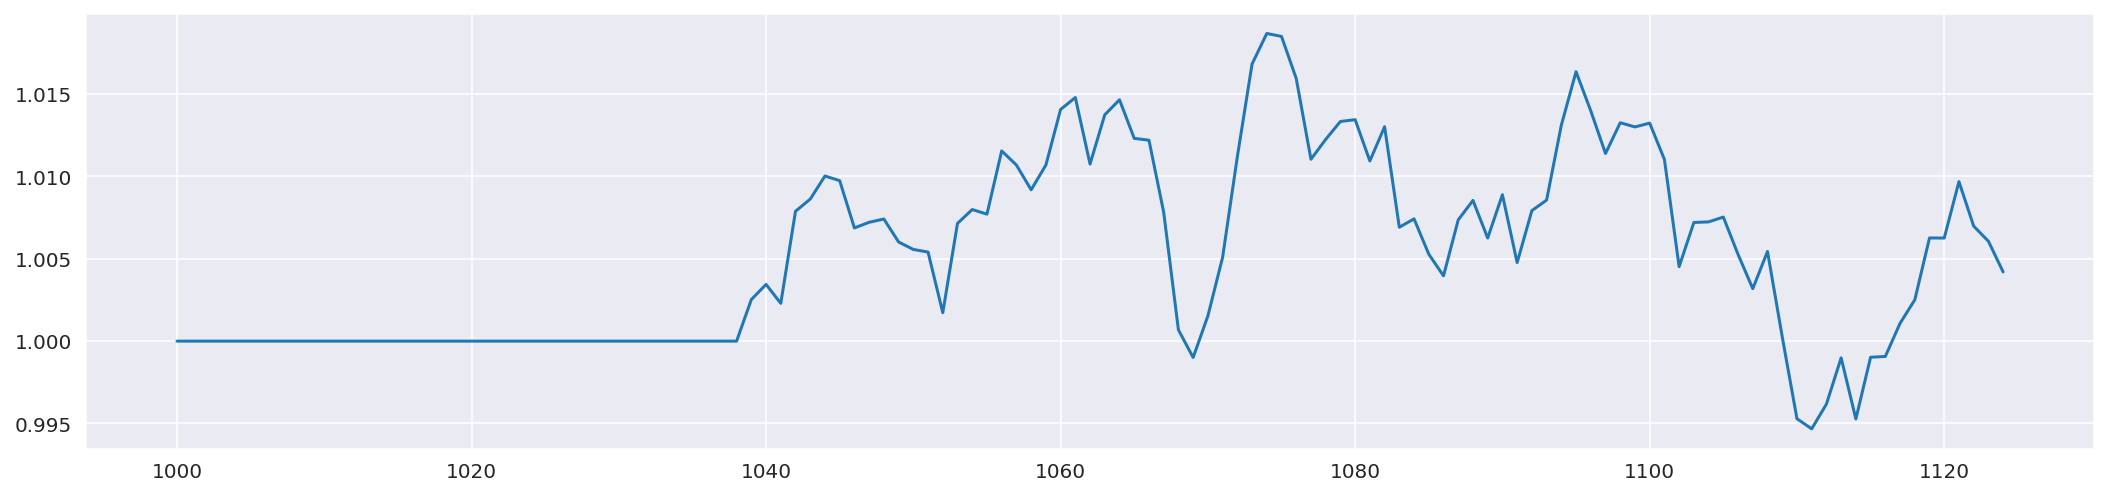

In [29]:
plt.figure(figsize=(18,4))
plt.plot(cumret)

### Partial cointegration

In [30]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    alpha_hat, beta_hat, rho_hat, sigmaM_hat, sigmaR_hat, _ = fit_pci(prices_train['S1'].values, 
                                                                      prices_train['S2'].values)

spread_train = prices_train['S2'] - alpha_hat - beta_hat * prices_train['S1']
spread_test = prices_test['S2'] - alpha_hat - beta_hat * prices_test['S1']

In [31]:
print(f'alpha = {alpha_hat}')
print(f'beta = {beta_hat}')
print(f'rho = {rho_hat}')
print(f'sigma_M = {sigmaM_hat}')
print(f'sigma_R = {sigmaR_hat}')

alpha = 4.617933048989684
beta = 1.006905457778673
rho = 0.6755710370005948
sigma_M = 0.6174839090024228
sigma_R = 0.41341438260793023


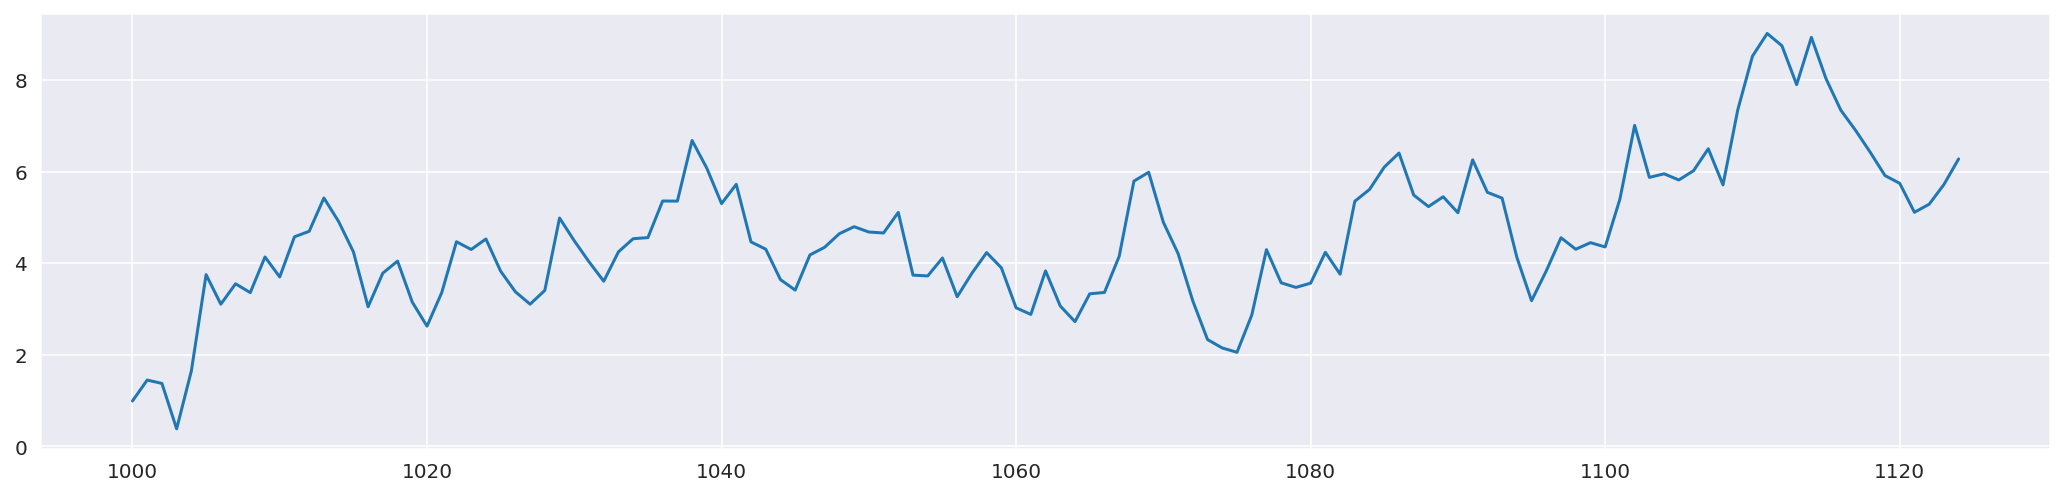

In [32]:
plt.figure(figsize=(18,4))
plt.plot(spread_test)

In [33]:
# separate mean reverting component
M,_,_ = kalman_estimate(spread_test.values, rho_hat, sigmaM_hat, sigmaR_hat)
M = pd.Series(M, index=spread_test.index)
sd = sigmaM_hat

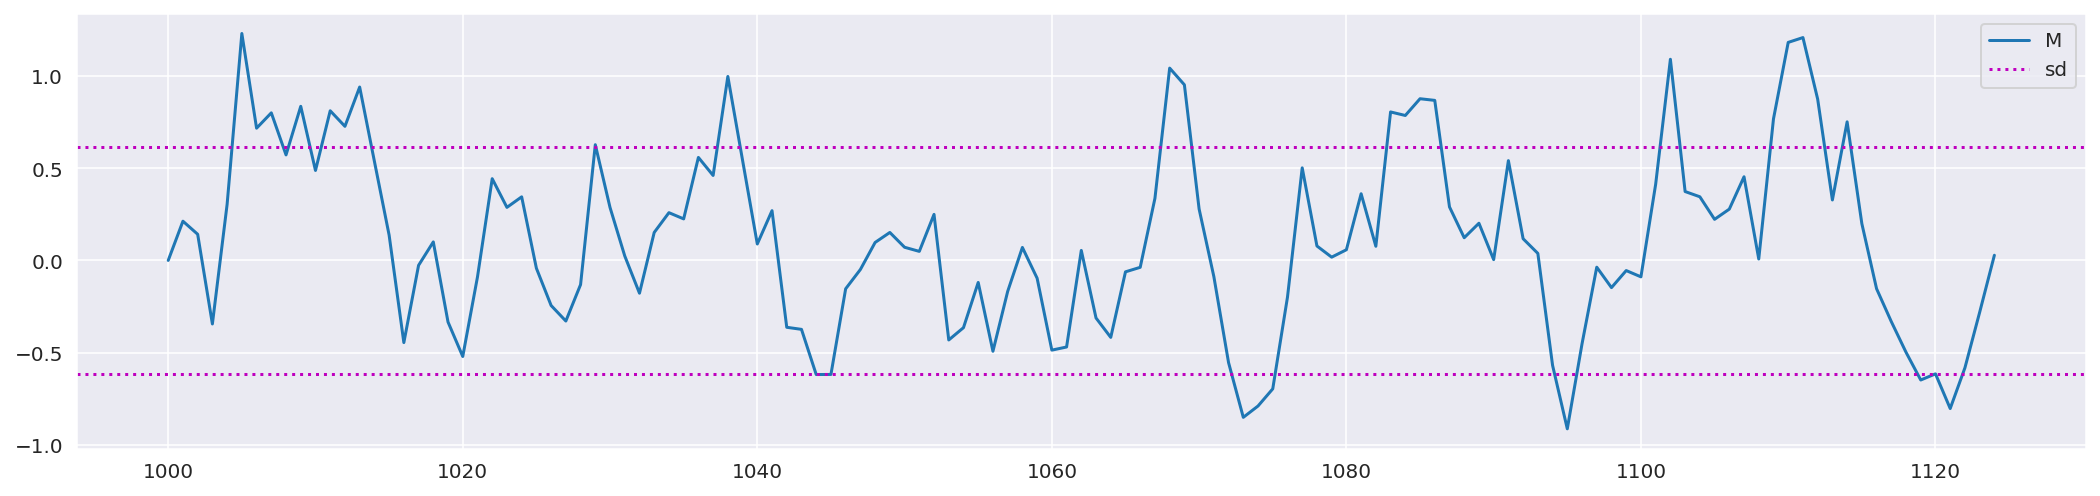

In [34]:
plt.figure(figsize=(18,4))
plt.plot(M, label='M')
plt.axhline(sd, label='sd', color='m', linestyle='dotted')
plt.axhline(-sd, color='m', linestyle='dotted')
plt.legend()

In [35]:
# indicators of long\short positions
short = False
long = False

positions = pd.DataFrame(index=M.index, columns=['S1','S2'])
for t in M.index:
    if M.loc[t] > 1*sd:
        short = True
        positions.loc[t] = [1,-1] # open short position
    elif M.loc[t] < -1*sd:
        long = True
        positions.loc[t] = [-1,1] # open long position
    elif short and M.loc[t] < -0.5*sd:
        short = False
        positions.loc[t] = [0,0] # close short position
    elif long and M.loc[t] > 0.5*sd:
        long = False
        positions.loc[t] = [0,0] # close long position
positions.fillna(method='ffill', inplace=True)
positions.fillna(0, inplace=True)

In [36]:
# calculate returns
ret = (positions.shift() * returns_test[['S1','S2']]).sum(axis=1)
cumret = np.cumprod(1+ret)

# calculate performance metrics
total_return, apr, sharpe, maxDD, maxDDD = calculate_metrics(cumret.values)

results_df.loc['Partial Cointegration Algo'] = total_return, apr, sharpe, maxDD, maxDDD
results_df

,Total return,APR,Sharpe,Max DD,Max DD Duration
Cointegration Algo,0.004201,0.008487,0.243088,-0.023573,50.0
Partial Cointegration Algo,0.039115,0.080423,2.163944,-0.012939,19.0


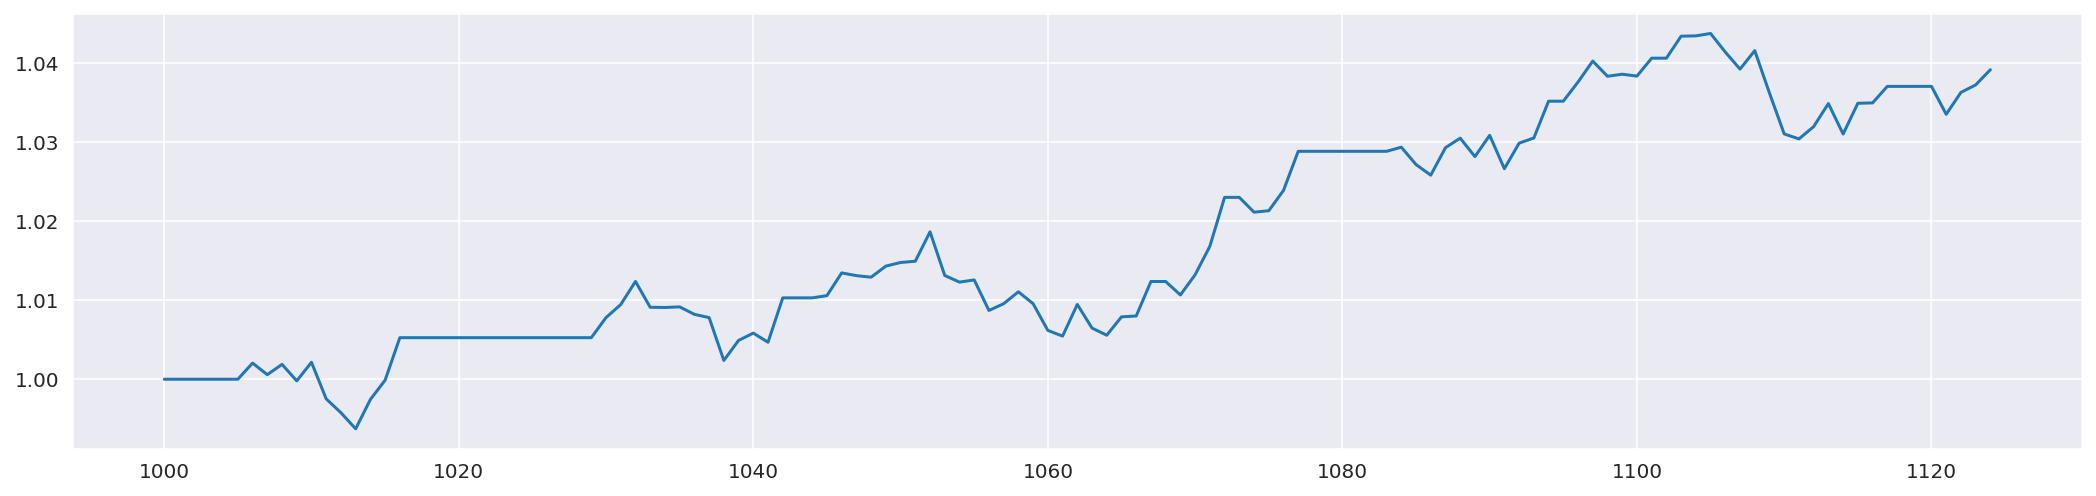

In [37]:
plt.figure(figsize=(18,4))
plt.plot(cumret)

# Sim studies

In [38]:
def ci_backtest(prices_train, prices_test, returns_test):
    '''
    Perform backtest of standard cointegration strategy
    '''
    
    S1,S2 = returns_test.columns
    
    # calculate spread parameters
    res = sm.OLS(prices_train[S2].values, sm.add_constant(prices_train[S1].values)).fit()
    alpha, beta = res.params
    spread_train = prices_train[S2] - alpha - beta * prices_train[S1]
    sd = spread_train.std()
    
    # calculate trading period spread
    spread_test = prices_test[S2] - alpha - beta * prices_test[S1]
    
    # perform backtest
    positions = pd.DataFrame(index=prices_test.index, columns=prices_test.columns)
    
    # indicators of long\short positions
    short = False
    long = False

    for t in spread_test.index:
        if spread_test.loc[t] > 2*sd:
            short = True
            positions.loc[t] = [1,-1] # open short position
        elif spread_test.loc[t] < -2*sd:
            long = True
            positions.loc[t] = [-1,1] # open long position
        elif short and spread_test.loc[t] < 0:
            short = False
            positions.loc[t] = [0,0] # close short position
        elif long and spread_test.loc[t] > 0:
            long = False
            positions.loc[t] = [0,0] # close long position
    positions.fillna(method='ffill', inplace=True)
    positions.fillna(0, inplace=True)
    
    # calculate returns
    ret = (positions.shift() * returns_test[[S1,S2]]).sum(axis=1)
    cumret = np.nancumprod(ret+1)
    
    return cumret

In [39]:
def pci_backtest(prices_train, prices_test, returns_test):
    '''
    Perform backtest of partial cointegration strategy
    '''
    
    S1,S2 = returns_test.columns
    
    # calculate spread parameters
    alpha, beta, rho, sigmaM, sigmaR, _ = fit_pci(prices_train[S1].values, prices_train[S2].values)
    
    # calculate spread
    spread_test = prices_test[S2] - alpha - beta * prices_test[S1]
    
    # separate mean reverting component
    M,_,_ = kalman_estimate(spread_test.values, rho, sigmaM, sigmaR)
    M = pd.Series(M, index=spread_test.index)
    sd = sigmaM
    
    # perform backtest
    # indicators of long\short positions
    short = False
    long = False

    positions = pd.DataFrame(index=M.index, columns=[S1,S2])
    for t in M.index:
        if M.loc[t] > 1*sd:
            short = True
            positions.loc[t] = [1,-1] # open short position
        elif M.loc[t] < -1*sd:
            long = True
            positions.loc[t] = [-1,1] # open long position
        elif short and M.loc[t] < -0.5*sd:
            short = False
            positions.loc[t] = [0,0] # close short position
        elif long and M.loc[t] > 0.5*sd:
            long = False
            positions.loc[t] = [0,0] # close long position
    positions.fillna(method='ffill', inplace=True)
    positions.fillna(0, inplace=True)
    
    # calculate returns
    ret = (positions.shift() * returns_test[[S1,S2]]).sum(axis=1)
    cumret = np.nancumprod(ret+1)
    
    return cumret

In [40]:
# set parameters
alpha = 5
beta = 1
sigma_X = 0.0236
rho = 0.7
sigma_M = 0.6
sigma_R = 0.4
N = 1125

N_sim = 5000
totrets_ci = []
sharpes_ci = []
totrets_pci = []
sharpes_pci = []

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    for i in tqdm(range(N_sim)):
        np.random.seed(i)
        X1,X2 = generate_pci(N, alpha,beta,sigma_X,rho,sigma_M,sigma_R)

        prices = pd.DataFrame(index=np.arange(len(X1)), columns=['S1','S2'])
        prices['S1'] = X1
        prices['S2'] = X2
        returns = prices.pct_change()

        prices_train = prices.iloc[:1000]
        prices_test = prices.iloc[1000:]
        returns_train = returns.iloc[:1000]
        returns_test = returns.iloc[1000:]

        cumret_ci = ci_backtest(prices_train, prices_test, returns_test)
        cumret_pci = pci_backtest(prices_train, prices_test, returns_test)
        
        totret_ci,_,sharpe_ci,_,_ = calculate_metrics(cumret_ci)
        totret_pci,_,sharpe_pci,_,_ = calculate_metrics(cumret_pci)

        totrets_ci.append(totret_ci)
        sharpes_ci.append(sharpe_ci)
        totrets_pci.append(totret_pci)
        sharpes_pci.append(sharpe_pci)

100%|██████████| 5000/5000 [48:55<00:00,  1.70it/s] 


In [41]:
def is_outlier(points, thresh=3.5):
    """
    https://stackoverflow.com/questions/11882393/matplotlib-disregard-outliers-when-plotting
    
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

In [44]:
totrets_ci = np.array(totrets_ci)
totrets_pci = np.array(totrets_pci)
totrets_ci_ = totrets_ci[~is_outlier(totrets_ci)]
totrets_pci_ = totrets_pci[~is_outlier(totrets_pci)]

Text(0.5, 1.0, 'Partial Cointegration')

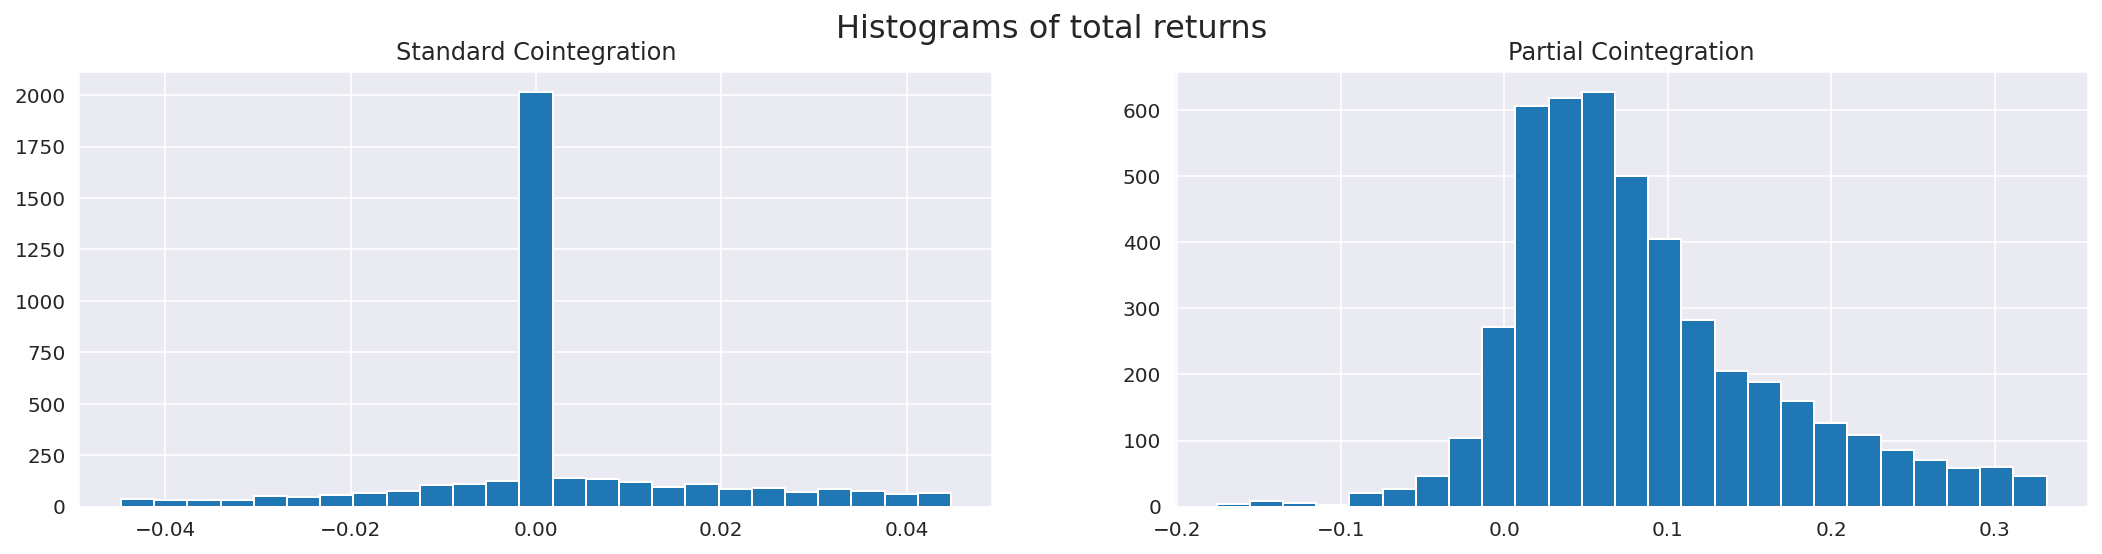

In [45]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(18,4))
fig.suptitle('Histograms of total returns', fontsize=16)
ax1.hist(totrets_ci_, bins=25)
ax1.set_title('Standard Cointegration')
ax2.hist(totrets_pci_, bins=25)
ax2.set_title('Partial Cointegration')

Text(0.5, 1.0, 'Partial Cointegration')

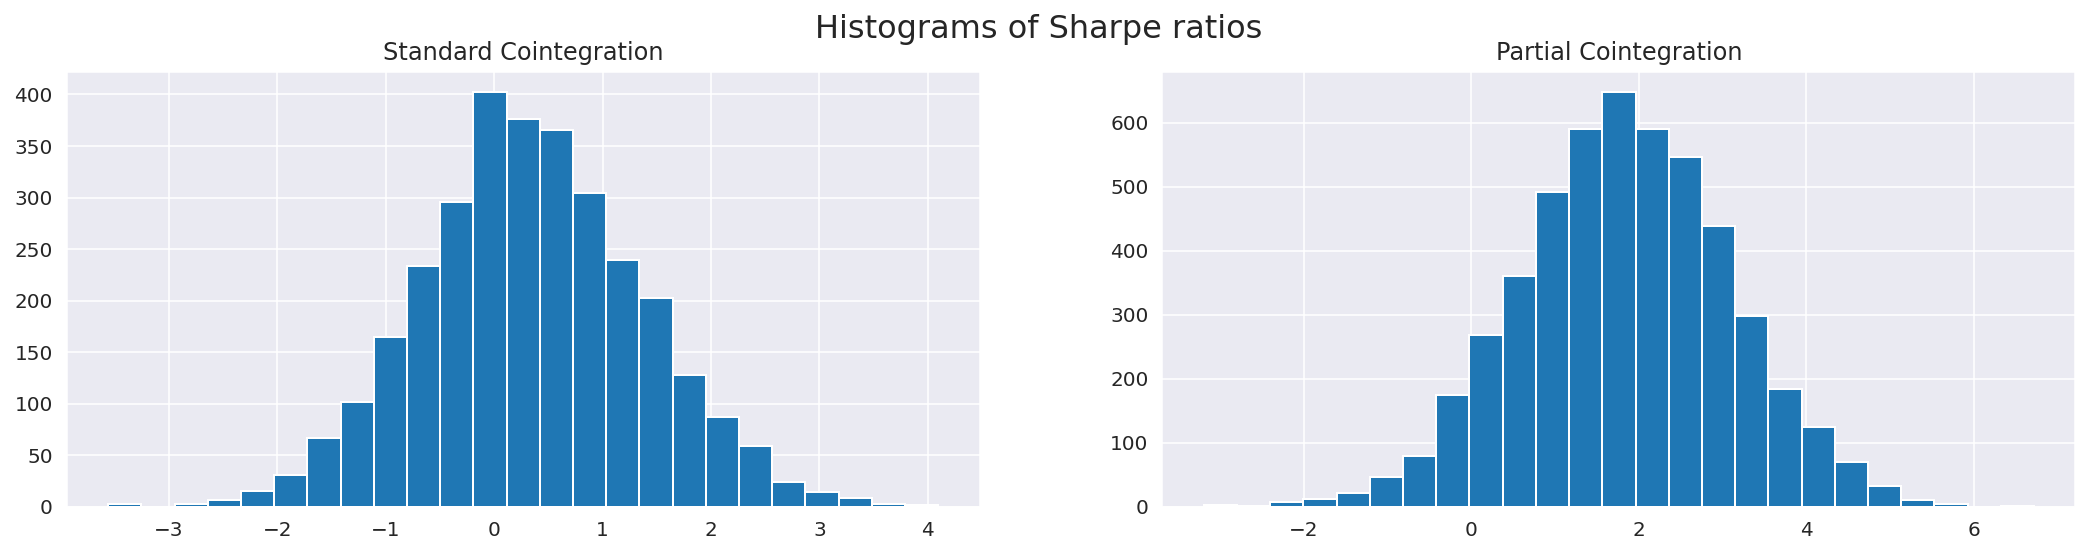

In [46]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(18,4))
fig.suptitle('Histograms of Sharpe ratios', fontsize=16)
ax1.hist(sharpes_ci, bins=25)
ax1.set_title('Standard Cointegration')
ax2.hist(sharpes_pci, bins=25)
ax2.set_title('Partial Cointegration')

# Trading with real data

### Load data

In [52]:
data = pd.read_csv('vbr0214.csv', index_col=0)
data = data.loc['2009-07-01':]
data = data.dropna(axis=1)

In [53]:
# select random stocks
np.random.seed(44)
stocks = np.random.choice(data.columns, size=100, replace=False)
stocks

array(['GCO', 'CRS', 'SCHN', 'AMG', 'LANC', 'ON', 'SLG', 'SWM', 'TCBI',
       'PNW', 'NWBI', 'NJR', 'GFF', 'KOP', 'JNPR', 'HA', 'CVI', 'ISBC',
       'NXGN', 'ASTE', 'NYT', 'UNM', 'ABG', 'SPWR', 'SYNA', 'GIC', 'MDC',
       'AMKR', 'SKYW', 'NSIT', 'RUSHA', 'BECN', 'FHN', 'PFS', 'ENR',
       'RLI', 'ACM', 'DBD', 'SNV', 'UFCS', 'SBGI', 'WW', 'SLM', 'GBX',
       'KNX', 'CLB', 'EQT', 'ALE', 'APOG', 'WABC', 'QRTEA', 'SSB', 'UHAL',
       'HRI', 'KALU', 'AZZ', 'CBSH', 'FSLR', 'SPR', 'KMPR', 'THO', 'ACHC',
       'M', 'USM', 'LTC', 'SAFT', 'CMC', 'MLI', 'XRX', 'INT', 'NHI',
       'RCII', 'DEI', 'SCL', 'WWW', 'BC', 'MTG', 'SWN', 'JWN', 'SRCL',
       'BCO', 'CMP', 'TOL', 'HNI', 'MIC', 'CORE', 'PRGO', 'WEN', 'TGNA',
       'MAC', 'CACI', 'EBIX', 'RGR', 'LAZ', 'SFNC', 'HLX', 'AUB', 'FUL',
       'TILE', 'WNC'], dtype=object)

In [54]:
data = data[stocks]
returns = data.pct_change()

In [55]:
data_train = data.loc[:'2013-06-30']
data_test = data.loc['2013-07-01':]
returns_train = returns.loc[:'2013-06-30']
returns_test = returns.loc['2013-07-01':]

# Standard Cointegration

In [56]:
def parse_pair(pair):
    s1 = pair[:pair.find('-')]
    s2 = pair[pair.find('-')+1:]
    return s1,s2

In [57]:
from statsmodels.tsa.stattools import adfuller

coint_res = pd.DataFrame(columns=['alpha', 'beta', 'ADF', 'Johansen'])

for s1 in tqdm(stocks):
    for s2 in stocks:
        if s1!=s2:
            adf = 0
            johansen = 0
            
            # ADF test
            res = sm.OLS(data_train[s2].values, sm.add_constant(data_train[s1].values)).fit()
            alpha, beta = res.params
            adf_pval = adfuller(res.resid)[1]
            if adf_pval < 0.05:
                adf = 1 # null is rejected at 95% level
            
            # Johansen test
            res = coint_johansen(data_train[[s1,s2]], det_order=0, k_ar_diff=1)
            if (res.lr2 > res.cvm[:,1]).sum() == 2:
                johansen = 1 # null is rejected at 95% level
                
            coint_res.loc[f'{s1}-{s2}'] = [alpha, beta, adf, johansen]

100%|██████████| 100/100 [09:27<00:00,  5.68s/it]


In [58]:
coint_res[(coint_res['ADF']==1) & (coint_res['Johansen']==1)]

,alpha,beta,ADF,Johansen
CRS-NSIT,6.582855,0.267348,1.0,1.0
CRS-KNX,22.887412,-0.061193,1.0,1.0
CRS-SFNC,10.478463,-0.012068,1.0,1.0
ON-CMC,7.631679,0.428700,1.0,1.0
ON-SFNC,8.647076,0.175767,1.0,1.0
...,...,...,...,...
TILE-CMP,28.652308,1.875292,1.0,1.0
TILE-SFNC,9.852326,0.016936,1.0,1.0
WNC-HA,6.298907,-0.046348,1.0,1.0
WNC-ASTE,20.903430,1.055839,1.0,1.0


In [62]:
pd.options.display.max_rows = 10

In [63]:
coint_res[(coint_res['ADF']==1) & 
          (coint_res['Johansen']==1) & 
          (coint_res['beta']>=0.75) & 
          (coint_res['beta']<=1.25)]

,alpha,beta,ADF,Johansen
GFF-KNX,9.758304,1.207094,1.0,1.0
HA-CMC,6.343480,0.789384,1.0,1.0
ASTE-GBX,-14.502303,1.028622,1.0,1.0
ASTE-KMPR,-0.668623,0.795214,1.0,1.0
SKYW-LAZ,6.141760,1.155197,1.0,1.0
...,...,...,...,...
SFNC-GFF,-2.972901,1.201191,1.0,1.0
SFNC-HA,-2.512073,0.845309,1.0,1.0
SFNC-SWN,28.882295,0.859200,1.0,1.0
TILE-ASTE,17.412442,0.870238,1.0,1.0


In [64]:
pairs = coint_res[(coint_res['ADF']==1) & 
          (coint_res['Johansen']==1) & 
          (coint_res['beta']>=0.75) & 
          (coint_res['beta']<=1.25)].index
pairs

Index(['GFF-KNX', 'HA-CMC', 'ASTE-GBX', 'ASTE-KMPR', 'SKYW-LAZ', 'NSIT-ASTE',
       'NSIT-KMPR', 'FHN-CMC', 'SBGI-HRI', 'GBX-CACI', 'KNX-WABC', 'KNX-XRX',
       'QRTEA-ASTE', 'QRTEA-NSIT', 'HRI-SBGI', 'SFNC-GFF', 'SFNC-HA',
       'SFNC-SWN', 'TILE-ASTE', 'WNC-ASTE'],
      dtype='object')

In [65]:
train_sharpe = pd.DataFrame(index=pairs, columns=['Sharpe'])

for pair in pairs:
    s1,s2 = parse_pair(pair)
    cumret = ci_backtest(data_train[[s1,s2]], data_train[[s1,s2]], returns_train[[s1,s2]])
    _,_,sharpe,_,_ = calculate_metrics(cumret)
    train_sharpe.loc[pair] = sharpe

In [66]:
pd.options.display.max_columns = 12

In [67]:
train_sharpe.sort_values(by='Sharpe', ascending=False).T

,SFNC-GFF,ASTE-GBX,QRTEA-ASTE,QRTEA-NSIT,NSIT-KMPR,SFNC-HA,...,NSIT-ASTE,TILE-ASTE,SBGI-HRI,SFNC-SWN,GBX-CACI,WNC-ASTE
Sharpe,1.802169,1.548942,1.471328,1.420099,1.298885,1.286273,...,0.919805,0.848882,0.789042,0.720228,0.077212,-0.276106


In [68]:
potential_pairs = train_sharpe[train_sharpe['Sharpe']>0].sort_values(by='Sharpe', ascending=False).index

In [69]:
len(potential_pairs)

19

In [70]:
selected_pairs = []
selected_stocks = []

for pair in potential_pairs:
    s1,s2 = parse_pair(pair)
    if (s1 not in selected_stocks) and (s2 not in selected_stocks):
        selected_pairs.append(pair)
        selected_stocks.append(s1)
        selected_stocks.append(s2)
    if len(selected_pairs) == 5:
        break

In [71]:
train_sharpe.loc[selected_pairs].T

,SFNC-GFF,ASTE-GBX,QRTEA-NSIT,KNX-XRX,FHN-CMC
Sharpe,1.802169,1.548942,1.420099,1.126057,1.078066


In [72]:
pair_ret = pd.DataFrame(index=returns_test.index, columns=selected_pairs)

for pair in selected_pairs:
    s1,s2 = parse_pair(pair)
    
    cumret = ci_backtest(data_train[[s1,s2]], data_test[[s1,s2]], returns_test[[s1,s2]])
    ret = pd.Series(cumret).pct_change().fillna(0).values
    pair_ret[pair] = ret

In [73]:
pair_ret

,SFNC-GFF,ASTE-GBX,QRTEA-NSIT,KNX-XRX,FHN-CMC
2013-07-01,0.000000,0.000000,0.0,0.000000,0.000000
2013-07-02,0.000000,0.000000,0.0,0.000000,0.000000
2013-07-03,0.000000,0.000000,0.0,0.000000,0.000000
2013-07-05,0.000000,0.000000,0.0,0.000000,0.000000
2013-07-08,0.000000,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...
2013-12-24,0.004591,0.000463,0.0,-0.008652,-0.011741
2013-12-26,-0.008938,-0.003595,0.0,-0.005735,-0.024967
2013-12-27,-0.015002,-0.009305,0.0,0.002104,-0.011133
2013-12-30,-0.004685,0.002308,0.0,0.001390,0.011948


In [74]:
pair_cumret = (pair_ret + 1).cumprod()
pair_cumret

,SFNC-GFF,ASTE-GBX,QRTEA-NSIT,KNX-XRX,FHN-CMC
2013-07-01,1.000000,1.000000,1.0,1.000000,1.000000
2013-07-02,1.000000,1.000000,1.0,1.000000,1.000000
2013-07-03,1.000000,1.000000,1.0,1.000000,1.000000
2013-07-05,1.000000,1.000000,1.0,1.000000,1.000000
2013-07-08,1.000000,1.000000,1.0,1.000000,1.000000
...,...,...,...,...,...
2013-12-24,0.937755,1.017226,1.0,0.953915,0.934939
2013-12-26,0.929373,1.013569,1.0,0.948445,0.911596
2013-12-27,0.915430,1.004138,1.0,0.950440,0.901448
2013-12-30,0.911141,1.006456,1.0,0.951761,0.912218


<AxesSubplot:>

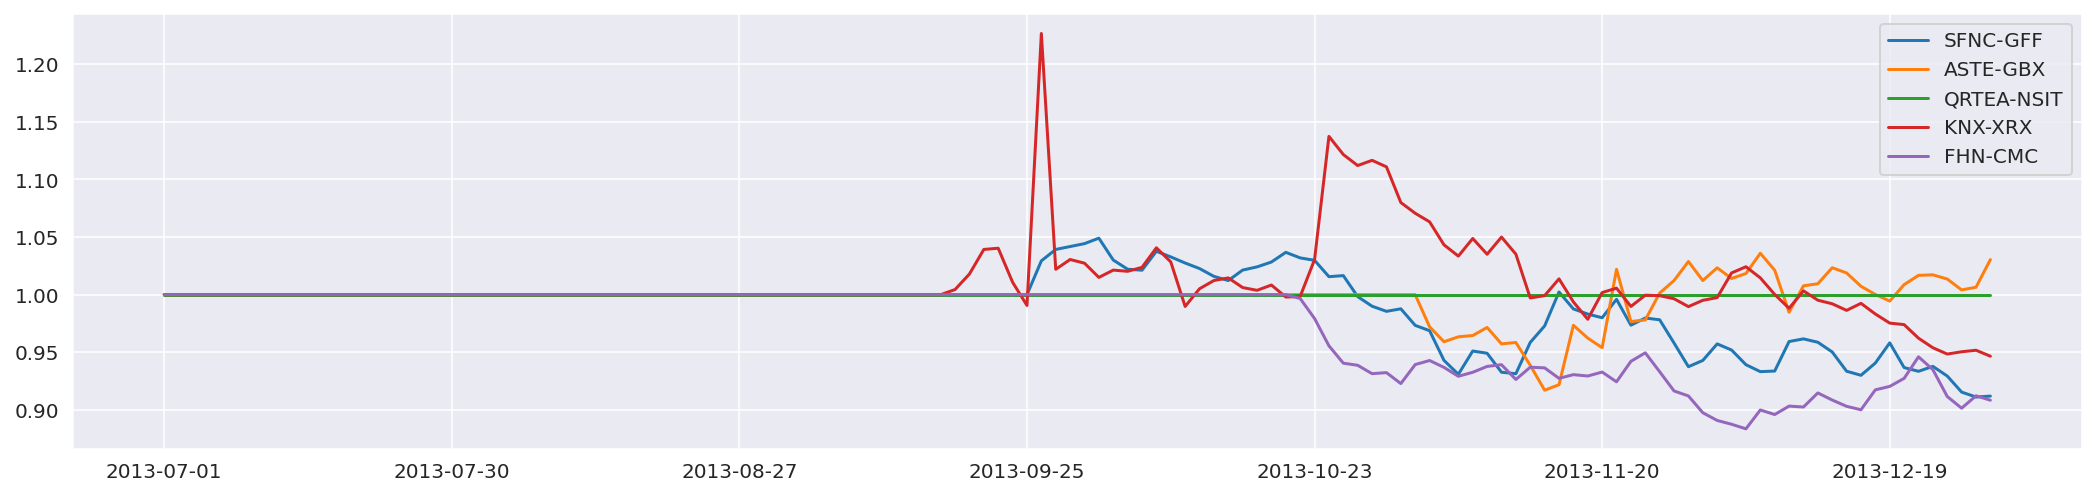

In [75]:
pair_cumret.plot(figsize=(18,4))

In [76]:
cumret = (pair_ret.sum(axis=1)/len(selected_pairs) + 1).cumprod()

In [77]:
results_df = pd.DataFrame(columns=['Total return', 'APR', 'Sharpe', 'Max DD', 'Max DD Duration'])
results_df.loc['Cointegration Algo'] = calculate_metrics(cumret.values)
results_df

,Total return,APR,Sharpe,Max DD,Max DD Duration
Cointegration Algo,-0.031111,-0.060327,-0.530588,-0.083533,66.0


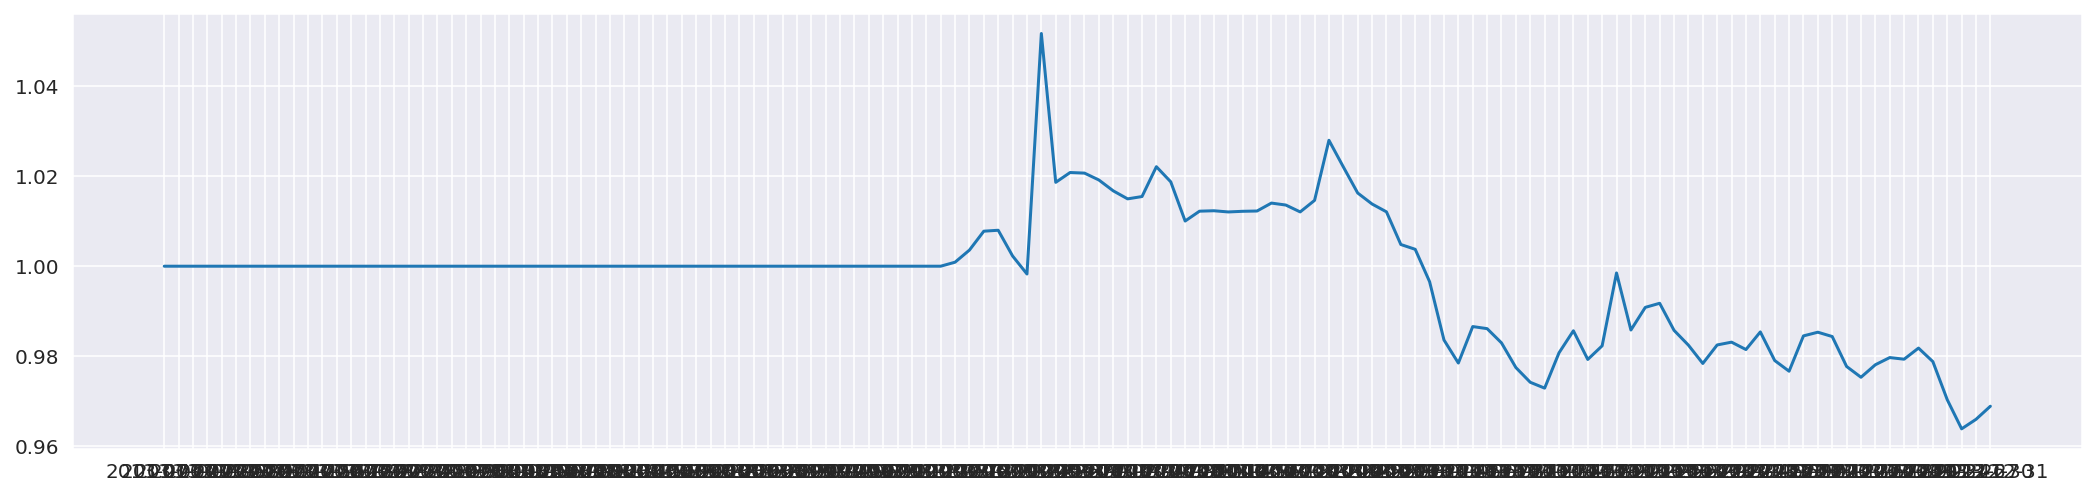

In [78]:
plt.figure(figsize=(18,4))
plt.plot(cumret)

# Partial cointegration

In [79]:
index = []

for s1 in data_train.columns:
    for s2 in data_train.columns:
        if s1!=s2:
            index.append(f'{s1}-{s2}')

In [383]:
'''
columns = ['AIC_AR', 'AIC_RW', 'AIC_PAR', 'alpha', 'beta', 'rho', 'sigma_M', 'sigma_R', 'R_sq']
pci_params = pd.DataFrame(index=index, columns=columns)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    for pair in tqdm(index):
        s1,s2 = parse_pair(pair)

        # fit PAR
        alpha_par, beta_par, rho_par, sigmaM_par, sigmaR_par, ll_par = fit_pci(data_train[s1].values, 
                                                                               data_train[s2].values,
                                                                               mode='PAR')
        aic_par = 2*3 - 2*ll_par
        
        # calculate R^2
        r_sq = calculate_Rsq(rho_par, sigmaM_par, sigmaR_par)
        
        if rho_par>0.5 and r_sq>0.5:

            # fit AR
            alpha_ar, beta_ar, rho_ar, sigmaM_ar, sigmaR_ar, ll_ar = fit_pci(data_train[s1].values, 
                                                                             data_train[s2].values,
                                                                             mode='AR')
            aic_ar = 2*2 - 2*ll_ar

            # fit RW
            alpha_rw, beta_rw, rho_rw, sigmaM_rw, sigmaR_rw, ll_rw = fit_pci(data_train[s1].values, 
                                                                             data_train[s2].values,
                                                                             mode='RW')
            aic_rw = 2*1 - 2*ll_rw

            row = [aic_ar, aic_rw, aic_par, alpha_par, beta_par, rho_par, sigmaM_par, sigmaR_par, r_sq]
            pci_params.loc[pair] = row

            pci_params.to_csv('pci_params.csv')
'''

100%|██████████| 9900/9900 [4:00:25<00:00,  1.46s/it]   


In [80]:
pci_params = pd.read_csv('pci_params.csv', index_col=0)
pci_params

,AIC_AR,AIC_RW,AIC_PAR,alpha,beta,rho,sigma_M,sigma_R,R_sq
GCO-CRS,2326.904518,2332.892079,2330.356927,9.194569,0.378877,0.932264,0.631018,0.439684,0.680705
GCO-SCHN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GCO-AMG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GCO-LANC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GCO-ON,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
WNC-SFNC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WNC-HLX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WNC-AUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WNC-FUL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [81]:
cond1 = (pci_params['AIC_PAR'] == pci_params[['AIC_AR', 'AIC_RW', 'AIC_PAR']].min(axis=1))
cond2 = (pci_params['rho'] > 0.5)
cond3 = (pci_params['R_sq'] > 0.5)
pci_params[cond1 & cond2 & cond3]

,AIC_AR,AIC_RW,AIC_PAR,alpha,beta,rho,sigma_M,sigma_R,R_sq
GCO-ABG,1382.674161,1381.963330,1379.467839,5.189239,0.260752,0.873945,0.342782,0.334874,0.527915
GCO-KNX,2103.912777,2109.776653,1992.756097,16.292956,0.147108,0.509379,0.597429,0.256545,0.877837
GCO-KALU,2115.829372,2118.660903,2106.248595,20.823788,0.315055,0.793588,0.530520,0.437978,0.620650
GCO-WWW,118.612049,117.626932,113.750447,6.749167,0.144343,0.852760,0.184236,0.176729,0.539832
GCO-JWN,1493.043270,1492.025374,1487.331779,8.080096,0.322965,0.822032,0.354266,0.360768,0.514201
...,...,...,...,...,...,...,...,...,...
WNC-KNX,2104.275490,2131.580450,1987.061328,18.989079,0.605177,0.528823,0.619604,0.190890,0.932354
WNC-MLI,310.339219,310.127682,308.756281,8.072756,0.597786,0.890032,0.200105,0.197714,0.520136
WNC-INT,1951.610609,1954.350922,1943.509790,18.383674,1.105818,0.853189,0.518131,0.366145,0.683659
WNC-RCII,1051.483031,1052.012447,1051.061813,13.642367,0.734553,0.937795,0.321959,0.248937,0.633217


In [85]:
cond4 = (pci_params['beta'] > 0.75) & (pci_params['beta'] < 1.25)
cond5 = (pci_params['rho'] < 0.8)
good_pairs = pci_params[cond1 & cond2 & cond3 & cond4 & cond5].index
good_pairs

Index(['ON-KNX', 'NJR-KNX', 'GFF-KNX', 'NYT-WABC', 'AMKR-KNX', 'RUSHA-WABC',
       'BECN-KALU', 'FHN-KNX', 'ACM-KALU', 'SBGI-KALU', 'QRTEA-KNX',
       'QRTEA-KMPR', 'HRI-KALU', 'CBSH-KNX', 'USM-KALU', 'XRX-ASTE',
       'MTG-WABC', 'BCO-KALU', 'CORE-KNX', 'WEN-RLI', 'TGNA-KNX', 'SFNC-KNX',
       'WNC-HNI'],
      dtype='object')

In [107]:
train_sharpe = pd.DataFrame(index=good_pairs, columns=['Sharpe'])
returns = {}

for pair in tqdm(good_pairs):
    s1,s2 = parse_pair(pair)
    
    # get model parameters
    alpha, beta, rho, sigma_M, sigma_R = pci_params.loc[pair, ['alpha', 'beta', 'rho', 'sigma_M', 'sigma_R']]
    
    # construct spread
    spread = data_train[s2] - alpha - beta*data_train[s1]
    # separate mean reverting component
    M,_,_ = kalman_estimate(spread.values, rho, sigma_M, sigma_R)
    M = pd.Series(M, index=spread.index)
    sd = sigma_M
    
    # indicators of long\short positions
    short = False
    long = False

    positions = pd.DataFrame(index=M.index, columns=[s1,s2])
    for t in M.index:
        if M.loc[t] > sd:
            short = True
            positions.loc[t] = [beta,-1] # open short position
        elif M.loc[t] < -sd:
            long = True
            positions.loc[t] = [-beta,1] # open long position
        elif short and M.loc[t] < -0.5*sd:
            short = False
            positions.loc[t] = [0,0] # close short position
        elif long and M.loc[t] > 0.5*sd:
            long = False
            positions.loc[t] = [0,0] # close long position
    positions.fillna(method='ffill', inplace=True)
    positions.fillna(0, inplace=True)
    
    # calculate returns
    ret = (positions.shift() * returns_train[[s1,s2]]).sum(axis=1) / 2
    train_sharpe.loc[pair] = np.sqrt(252) * np.nanmean(ret) / np.nanstd(ret)
    returns[pair] = ret

100%|██████████| 23/23 [00:01<00:00, 22.43it/s]


In [108]:
train_sharpe.sort_values(by='Sharpe', ascending=False)

,Sharpe
XRX-ASTE,1.418368
QRTEA-KMPR,1.378608
WEN-RLI,1.027233
CBSH-KNX,1.008091
TGNA-KNX,0.973765
...,...
CORE-KNX,0.633734
NJR-KNX,0.630748
RUSHA-WABC,0.446472
ACM-KALU,0.438856


In [109]:
potential_pairs = train_sharpe[train_sharpe['Sharpe']>0].sort_values(by='Sharpe', ascending=False).index

In [110]:
len(potential_pairs)

23

In [111]:
selected_pairs = []
selected_stocks = []

for pair in potential_pairs:
    s1,s2 = parse_pair(pair)
    if (s1 not in selected_stocks) and (s2 not in selected_stocks):
        selected_pairs.append(pair)
        selected_stocks.append(s1)
        selected_stocks.append(s2)

In [113]:
len(selected_pairs)

7

In [115]:
selected_pairs = selected_pairs[:5]

In [116]:
pci_params.loc[selected_pairs]

,AIC_AR,AIC_RW,AIC_PAR,alpha,beta,rho,sigma_M,sigma_R,R_sq
XRX-ASTE,1772.089797,1776.831310,1767.986373,12.743432,1.011787,0.782287,0.419591,0.402444,0.549512
QRTEA-KMPR,752.770132,763.521376,739.805772,5.441331,1.248207,0.693363,0.270837,0.219458,0.642709
WEN-RLI,-139.219019,-137.371081,-160.037151,8.086535,1.123077,0.512520,0.147634,0.166846,0.508674
CBSH-KNX,2066.958022,2080.760095,1957.420254,8.415957,0.763981,0.525451,0.595977,0.230093,0.897917
SBGI-KALU,2240.473203,2244.704429,2234.957846,25.734352,0.886369,0.782381,0.539264,0.497126,0.569037


In [160]:
pair_ret = pd.DataFrame(index=returns_test.index, columns=selected_pairs)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    for pair in selected_pairs:
        print(f'Processing pair {pair} ...')
        s1,s2 = parse_pair(pair)

        # indicators of long\short positions
        short = False
        long = False

        positions = pd.DataFrame(index=data_test.index, columns=[s1,s2])
        for t in tqdm(data_test.index):
            # prepare data
            data_tmp = data.loc[:t]
            data_tmp = data_tmp.iloc[-125:]
            # get parameters
            alpha, beta, rho, sigma_M, sigma_R = pci_params.loc[pair][['alpha', 'beta', 'rho', 
                                                                      'sigma_M', 'sigma_R']]
            # calculate spread
            spread = data_tmp[s2] - alpha - beta * data_tmp[s1]
            # separate mean reverting component
            M,_,_ = kalman_estimate(spread.values, rho, sigma_M, sigma_R)
            z_score = M[-1] / sigma_M

            if z_score > 1:
                short = True
                positions.loc[t] = [1,-1] # open short position
            elif z_score < -1:
                long = True
                positions.loc[t] = [-1,1] # open long position
            elif short and z_score < -0.5:
                short = False
                positions.loc[t] = [0,0] # close short position
            elif long and z_score > 0.5:
                long = False
                positions.loc[t] = [0,0] # close long position
        positions.fillna(method='ffill', inplace=True)
        positions.fillna(0, inplace=True)

        # calculate returns
        ret = (positions.shift() * returns_test[[s1,s2]]).sum(axis=1)
        pair_ret[pair] = ret

Processing pair XRX-ASTE ...


100%|██████████| 128/128 [00:00<00:00, 538.76it/s]


Processing pair QRTEA-KMPR ...


100%|██████████| 128/128 [00:00<00:00, 619.54it/s]


Processing pair WEN-RLI ...


100%|██████████| 128/128 [00:00<00:00, 690.50it/s]


Processing pair CBSH-KNX ...


100%|██████████| 128/128 [00:00<00:00, 859.81it/s]


Processing pair SBGI-KALU ...


100%|██████████| 128/128 [00:00<00:00, 841.55it/s]


In [161]:
pair_ret

,XRX-ASTE,QRTEA-KMPR,WEN-RLI,CBSH-KNX,SBGI-KALU
2013-07-01,0.0,0.000000,0.000000,0.0,0.0
2013-07-02,0.0,-0.004718,0.000129,0.0,0.0
2013-07-03,0.0,0.000715,-0.005887,0.0,0.0
2013-07-05,0.0,0.002453,-0.007273,0.0,0.0
2013-07-08,0.0,0.003545,-0.004303,0.0,0.0
...,...,...,...,...,...
2013-12-24,0.0,0.000000,0.000000,0.0,0.0
2013-12-26,0.0,0.000000,0.000000,0.0,0.0
2013-12-27,0.0,0.000000,0.000000,0.0,0.0
2013-12-30,0.0,0.000000,0.000000,0.0,0.0


In [162]:
pair_cumret = (pair_ret + 1).cumprod()
pair_cumret

,XRX-ASTE,QRTEA-KMPR,WEN-RLI,CBSH-KNX,SBGI-KALU
2013-07-01,1.000000,1.000000,1.000000,1.00000,1.000000
2013-07-02,1.000000,0.995282,1.000129,1.00000,1.000000
2013-07-03,1.000000,0.995994,0.994241,1.00000,1.000000
2013-07-05,1.000000,0.998437,0.987010,1.00000,1.000000
2013-07-08,1.000000,1.001976,0.982763,1.00000,1.000000
...,...,...,...,...,...
2013-12-24,1.196139,1.339333,1.080646,1.22919,0.897634
2013-12-26,1.196139,1.339333,1.080646,1.22919,0.897634
2013-12-27,1.196139,1.339333,1.080646,1.22919,0.897634
2013-12-30,1.196139,1.339333,1.080646,1.22919,0.897634


<AxesSubplot:>

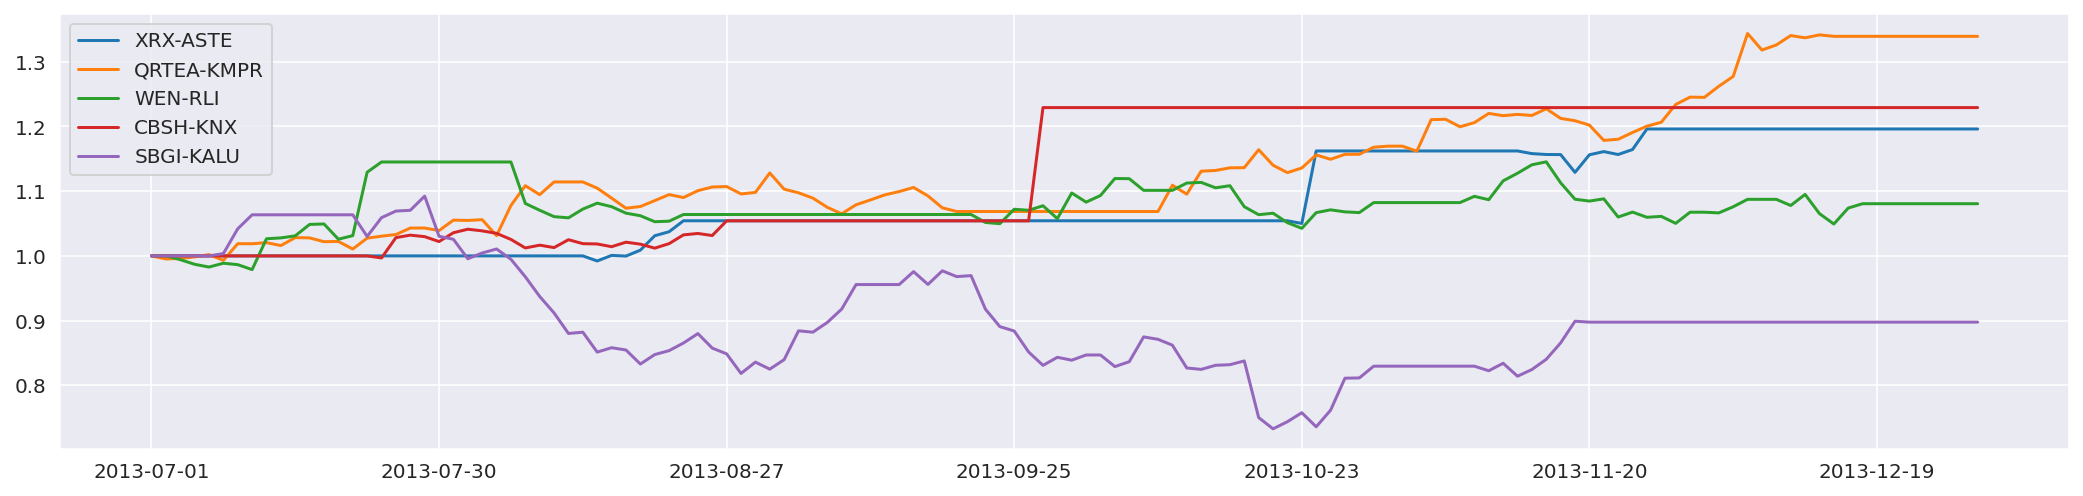

In [163]:
pair_cumret.plot(figsize=(18,4))

In [164]:
cumret = (pair_ret.sum(axis=1)/len(selected_pairs) + 1).cumprod()

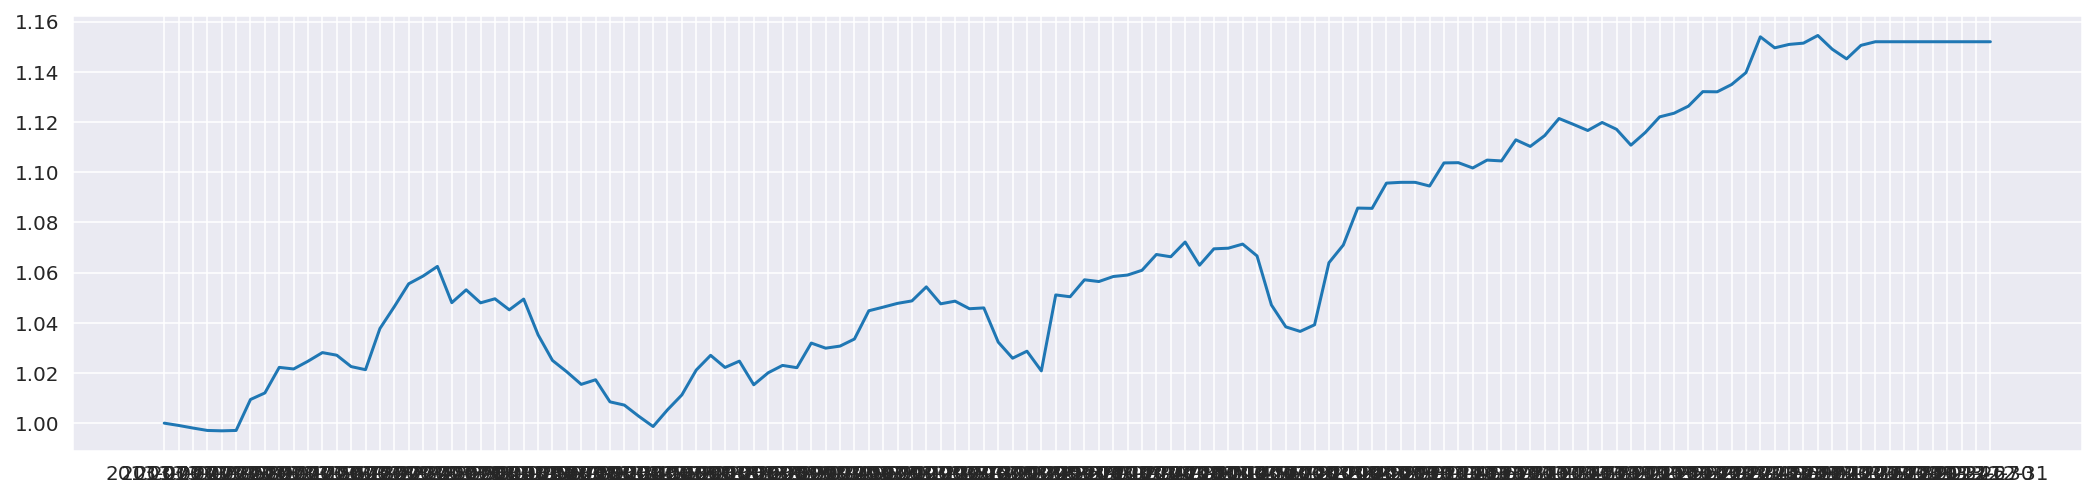

In [165]:
plt.figure(figsize=(18,4))
plt.plot(cumret)

In [166]:
results_df.loc['Partial Cointegration Algo'] = calculate_metrics(cumret.values)
results_df

,Total return,APR,Sharpe,Max DD,Max DD Duration
Cointegration Algo,-0.031111,-0.060327,-0.530588,-0.083533,66.0
Partial Cointegration Algo,0.151967,0.321174,2.793322,-0.060040,49.0
